# Imports

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Not needed anymore
from scipy.stats import mode
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Data loading

In [124]:
!unzip hw3data.zip
!rm hw3data.zip

unzip:  cannot find or open hw3data.zip, hw3data.zip.zip or hw3data.zip.ZIP.
rm: cannot remove 'hw3data.zip': No such file or directory


In [125]:
filename = './hw3Data/emails.csv'
# data = pd.read_csv(filename, 'r', encoding='utf8', sep='\n')
rawdata = []
with open(filename) as f:
  rawdata = f.readlines()

In [126]:
data = pd.DataFrame(columns=rawdata[0].split(','), data=[row.split(',') for row in rawdata[1:]])
data.head()

Email No. the  to ect and for of    a you hou  ... connevey jay valued lay  \
0   Email 1   0   0   1   0   0  0    2   0   0  ...        0   0      0   0   
1   Email 2   8  13  24   6   6  2  102   1  27  ...        0   0      0   0   
2   Email 3   0   0   1   0   0  0    8   0   0  ...        0   0      0   0   
3   Email 4   0   5  22   0   5  1   51   2  10  ...        0   0      0   0   
4   Email 5   7   6  17   1   5  2   57   0   9  ...        0   0      0   0   

  infrastructure military allowing ff dry Prediction\n  
0              0        0        0  0   0          0\n  
1              0        0        0  1   0          0\n  
2              0        0        0  0   0          0\n  
3              0        0        0  0   0          0\n  
4              0        0        0  1   0          0\n  

[5 rows x 3002 columns]

In [127]:
data.drop(columns='Email No.', inplace=True)
preds = [s[0] for s in data['Prediction\n'].to_list()]
data.drop(columns='Prediction\n', inplace=True)
data['Prediction'] = preds
print(data.shape)
data.head()

(5000, 3001)


the  to ect and for of    a you hou  in  ... connevey jay valued lay  \
0   0   0   1   0   0  0    2   0   0   0  ...        0   0      0   0   
1   8  13  24   6   6  2  102   1  27  18  ...        0   0      0   0   
2   0   0   1   0   0  0    8   0   0   4  ...        0   0      0   0   
3   0   5  22   0   5  1   51   2  10   1  ...        0   0      0   0   
4   7   6  17   1   5  2   57   0   9   3  ...        0   0      0   0   

  infrastructure military allowing ff dry Prediction  
0              0        0        0  0   0          0  
1              0        0        0  1   0          0  
2              0        0        0  0   0          0  
3              0        0        0  0   0          0  
4              0        0        0  1   0          0  

[5 rows x 3001 columns]

# Data prep

In [128]:
data = data.astype(float)

In [129]:
# data.head(10)

In [130]:
X_train = data.iloc[:4000, :-1].to_numpy()
y_train = data.iloc[:4000, -1].to_numpy()
X_test = data.iloc[4000:, :-1].to_numpy()
y_test = data.iloc[4000:, -1].to_numpy()

X_full = data.iloc[:, :-1].to_numpy()
y_full = data.iloc[:, -1].to_numpy()

In [131]:
X_train_std = (X_train - X_train.mean(axis=0))/(X_train.std(axis=0) + 1e-30)
X_test_std = (X_test - X_test.mean(axis=0))/(X_test.std(axis=0) + 1e-30)
X_full_std = (X_full - X_full.mean(axis=0))/(X_full.std(axis=0) + 1e-30)

In [132]:
# Min-Max Scaling for X_train, X_test, and X_full
min_value = 0
max_value = 1

X_train_minmax = (X_train - X_train.min(axis=0)) / (X_train.max(axis=0) - X_train.min(axis=0) + 1e-30)
X_test_minmax = (X_test - X_test.min(axis=0)) / (X_test.max(axis=0) - X_test.min(axis=0) + 1e-30)
X_full_minmax = (X_full - X_full.min(axis=0)) / (X_full.max(axis=0) - X_full.min(axis=0) + 1e-30)

# Helper functions

## Performance Metrics

In [21]:
def precision_metric(pred, test):
  true_positives = sum((test == 1) & (pred == 1))
  false_positives = sum((test == 0) & (pred == 1))

  if true_positives + false_positives == 0:
      return 0  # Handle the case where there are no predicted positives

  return true_positives / (true_positives + false_positives)

def recall_metric(pred, test):
  true_positives = sum((test == 1) & (pred == 1))
  false_negatives = sum((test == 1) & (pred == 0))

  if true_positives + false_negatives == 0:
      return 0  # Handle the case where there are no actual positives

  return true_positives / (true_positives + false_negatives)

## KNN Classifier

In [61]:
def knn_classifier(X_train, y_train, X_test, k=3):
  num_test_points = X_test.shape[0]
  y_pred = np.zeros(num_test_points, dtype=float)
  y_prob = np.zeros(num_test_points, dtype=float)
  y_train = y_train.astype('int')

  for i in range(num_test_points):
    distances = np.sqrt(np.sum((X_train - X_test[i])**2, axis=1))
    # distances = np.sum(np.abs(X_train - X_test[i]), axis=1)
    closest_y = np.argsort(distances, kind='mergesort')[:k]
    labels = y_train[closest_y]
    y_pred[i] = np.argmax(np.bincount(labels))
    y_prob[i] = sum(labels)/len(labels)

  return y_pred, y_prob

def knn_crossval(features, labels, folds=5, ks=[1, 3, 5, 7, 10]):
  fold_size = 5000//5
  accuracies = []
  for i in range(5):
    start = i*fold_size
    end = start + fold_size
    test = X_full[start:end]
    test_label = labels[start:end]
    train = np.concatenate((features[:start], features[end:]), axis=0)
    train_label = np.concatenate((labels[:start], labels[end:]), axis=0)
    acc = []
    prec = []
    rec = []

    for k in ks:
      print(f"Fold {i+1} with k = {k}")
      preds, probs = knn_classifier(train, train_label, test, k=k)
      accuracy = (test_label == preds).sum() / len(preds)
      precision = precision_metric(preds, test_label)
      recall = recall_metric(preds, test_label)
      print("Accuracy on the test set:", accuracy)
      print("Precision on the test set:", precision)
      print("Recall on the test set:", recall)
      acc.append(accuracy)
    accuracies.append(acc)
  return accuracies

def plot_knn(accuracies):
  accuracies = np.array(accuracies)
  xvals = [1, 3, 5, 7, 10]
  yvals = accuracies.mean(axis=0)

  plt.plot(xvals, yvals, 'bo-')
  plt.xlabel("k")
  plt.ylabel("Average accuracy")
  plt.title("kNN 5-Fold Cross Validation")
  plt.grid()
  plt.show()

In [23]:
# pred, prob = knn_classifier(X_train, y_train, X_test, k=1)

In [24]:
accuracies = knn_crossval(X_full, y_full, ks=[1])

Fold 1 with k = 1
Accuracy on the test set: 0.825
Precision on the test set: 0.6544943820224719
Recall on the test set: 0.8175438596491228
Fold 2 with k = 1
Accuracy on the test set: 0.853
Precision on the test set: 0.6857142857142857
Recall on the test set: 0.8664259927797834
Fold 3 with k = 1
Accuracy on the test set: 0.862
Precision on the test set: 0.7212121212121212
Recall on the test set: 0.8380281690140845
Fold 4 with k = 1
Accuracy on the test set: 0.851
Precision on the test set: 0.7164179104477612
Recall on the test set: 0.8163265306122449
Fold 5 with k = 1
Accuracy on the test set: 0.775
Precision on the test set: 0.6057441253263708
Recall on the test set: 0.7581699346405228


In [28]:
accuracies = knn_crossval(X_full, y_full)

Fold 1 with k = 1
Accuracy on the test set: 0.825
Precision on the test set: 0.6544943820224719
Recall on the test set: 0.8175438596491228
Fold 1 with k = 3
Accuracy on the test set: 0.847
Precision on the test set: 0.680327868852459
Recall on the test set: 0.8736842105263158
Fold 1 with k = 5
Accuracy on the test set: 0.838
Precision on the test set: 0.6694214876033058
Recall on the test set: 0.8526315789473684
Fold 1 with k = 7
Accuracy on the test set: 0.838
Precision on the test set: 0.6694214876033058
Recall on the test set: 0.8526315789473684
Fold 1 with k = 10
Accuracy on the test set: 0.862
Precision on the test set: 0.7333333333333333
Recall on the test set: 0.8105263157894737
Fold 2 with k = 1
Accuracy on the test set: 0.853
Precision on the test set: 0.6857142857142857
Recall on the test set: 0.8664259927797834
Fold 2 with k = 3
Accuracy on the test set: 0.851
Precision on the test set: 0.6975308641975309
Recall on the test set: 0.8158844765342961
Fold 2 with k = 5
Accuracy 

In [29]:
accuracies

[[0.825, 0.847, 0.838, 0.838, 0.862],
 [0.853, 0.851, 0.85, 0.862, 0.87],
 [0.862, 0.86, 0.873, 0.875, 0.876],
 [0.851, 0.88, 0.869, 0.874, 0.887],
 [0.775, 0.774, 0.779, 0.778, 0.781]]

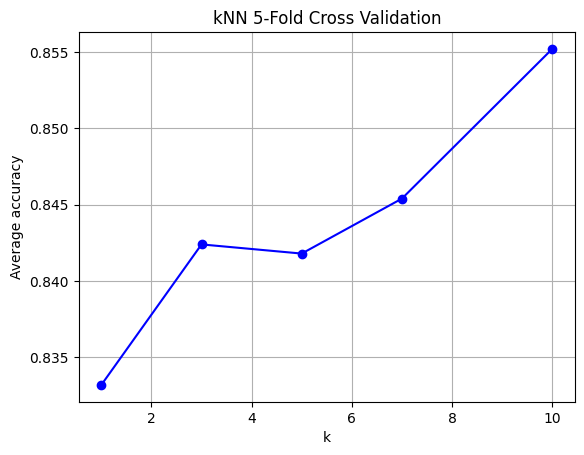

In [30]:
plot_knn(accuracies)

## Logistic Regression

In [31]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

def loss(h, y):
  h = h + 1e-10
  y = y
  # print(h)
  # print(y)
  return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

def logistic_accuracy(features, theta, labels):
  predictions = predict_logistic_regression(features, theta)
  accuracy = (predictions == labels).sum() / len(predictions)
  return accuracy

def probability(features, theta, labels):
  features = np.hstack((np.ones((features.shape[0], 1)), features))
  predictions = sigmoid(np.dot(features, theta))
  return predictions

def train_logistic_regression(features, labels, test_features, test_labels, lr=0.1, epochs=4000): # returns weights
  features = np.hstack((np.ones((features.shape[0], 1)), features))
  theta = np.random.normal(0.001,0.01,features.shape[1])
  loss_history = []
  accuracy_history = []

  for i in range(epochs):
    predictions = sigmoid(np.dot(features, theta))
    loss_history.append(loss(predictions, labels))
    update = np.dot(features.T, (predictions - labels)) / labels.size
    theta = theta - lr*update
    accuracy_history.append(logistic_accuracy(test_features, theta, test_labels)*100)

  return theta, loss_history, accuracy_history

def predict_logistic_regression(features, theta):
  features = np.hstack((np.ones((features.shape[0], 1)), features))
  predictions = np.round(sigmoid(np.dot(features, theta)))
  return predictions

def log_crossval(features, labels, folds=5):
  fold_size = 5000//5
  accuracies = []
  for i in range(5):
    start = i*fold_size
    end = start + fold_size
    test = features[start:end]
    test = (test - test.min(axis=0)) / (test.max(axis=0) - test.min(axis=0) + 1e-30)
    test_label = labels[start:end]
    train = np.concatenate((features[:start], features[end:]), axis=0)
    train = (train - train.min(axis=0)) / (train.max(axis=0) - train.min(axis=0) + 1e-30)
    train_label = np.concatenate((labels[:start], labels[end:]), axis=0)
    acc = []
    prec = []
    rec = []

    print(f"Fold {i+1}")
    theta, loss_history, accuracy_history = train_logistic_regression(train, train_label, test, test_label)
    preds = predict_logistic_regression(test, theta)
    accuracy = (test_label == preds).sum() / len(preds)
    precision = precision_metric(preds, test_label)
    recall = recall_metric(preds, test_label)
    print("Accuracy on the test set:", accuracy)
    print("Precision on the test set:", precision)
    print("Recall on the test set:", recall)
    accuracies.append(accuracy)
  return accuracies

In [32]:
log_crossval(X_full, y_full)

Fold 1
Accuracy on the test set: 0.93
Precision on the test set: 0.9423868312757202
Recall on the test set: 0.8035087719298246
Fold 2
Accuracy on the test set: 0.966
Precision on the test set: 0.9655172413793104
Recall on the test set: 0.9097472924187726
Fold 3
Accuracy on the test set: 0.906
Precision on the test set: 0.975
Recall on the test set: 0.6866197183098591
Fold 4
Accuracy on the test set: 0.916
Precision on the test set: 0.9375
Recall on the test set: 0.7653061224489796
Fold 5
Accuracy on the test set: 0.934
Precision on the test set: 0.9444444444444444
Recall on the test set: 0.8333333333333334


[[], [], [], [], []]

In [ ]:
theta, loss_history, accuracy_history = train_logistic_regression(X_train_minmax, y_train, X_test_minmax, y_test)
preds = predict_logistic_regression(X_test_minmax, theta)
accuracy = (y_test == preds).sum() / len(preds)
precision = precision_metric(preds, y_test)
recall = recall_metric(preds, y_test)
print("Accuracy on the test set:", accuracy)
print("Precision on the test set:", precision)
print("Recall on the test set:", recall)

Accuracy on the test set: 0.934
Precision on the test set: 0.9511278195488722
Recall on the test set: 0.826797385620915


# Part 1

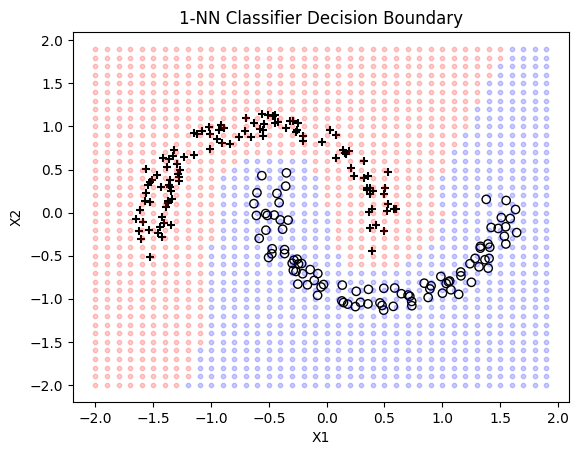

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

data = np.loadtxt("hw3Data/D2z.txt", delimiter=' ')

X_train = data[:, :2]
y_train = data[:, 2]

x_min, x_max = -2, 2
y_min, y_max = -2, 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
test_points = np.array([*zip(xx.flatten(), yy.flatten())])
# print(test_points)

pred_labels, _ = knn_classifier(X_train, y_train, test_points, k=1)
newdata = np.hstack((test_points, pred_labels[:, np.newaxis]))
# print(newdata)

pos = data[data[:, -1] == 1]
neg = data[data[:, -1] == 0]
plt.scatter(pos[:, 0], pos[:, 1], marker='+', color='black', label='Training Data positive class')
plt.scatter(neg[:, 0], neg[:, 1], marker='o', facecolors='none', edgecolors='black', label='Training Data negative class')

pos = newdata[newdata[:, -1] == 1]
neg = newdata[newdata[:, -1] == 0]
plt.scatter(pos[:, 0], pos[:, 1], color='red', alpha=0.2, s=10)
plt.scatter(neg[:, 0], neg[:, 1], color='blue', alpha=0.2, s=10)


plt.xlabel('X1')
plt.ylabel('X2')
plt.title('1-NN Classifier Decision Boundary')
# plt.legend()
plt.show()

# Combined ROC

In [142]:
def calculate_auc(fp, tp):
    auc = 0
    prev_fpr, prev_tpr = 0, 0

    for fpr, tpr in zip(fp, tp):
        auc += 0.5 * (tpr + prev_tpr) * (fpr - prev_fpr)
        prev_fpr, prev_tpr = fpr, tpr

    return auc

def calculate_roc_curve(predictions, labels):
    m = len(predictions)
    sorted_indices = sorted(range(m), key=lambda i: predictions[i], reverse=True)
    sorted_labels = [labels[i] for i in sorted_indices]

    num_neg = sorted_labels.count(0)
    num_pos = sorted_labels.count(1)

    TP = 0
    FP = 0
    last_TP = 0
    roc_curve_points = [(0, 0)]

    for i in range(m):
        if i > 0 and predictions[sorted_indices[i]] != predictions[sorted_indices[i-1]] and sorted_labels[i] == 0 and TP > last_TP:
            FPR = FP / num_neg
            TPR = TP / num_pos
            roc_curve_points.append((FPR, TPR))
            last_TP = TP

        if sorted_labels[i] == 1:
            TP += 1
        else:
            FP += 1

    FPR = FP / num_neg
    TPR = TP / num_pos
    roc_curve_points.append((FPR, TPR))

    return roc_curve_points

def plot_roc_curve(log_predictions, knn_predictions, labels):
  log_roc_curve = calculate_roc_curve(log_predictions, labels)
  knn_roc_curve = calculate_roc_curve(knn_predictions, labels)

  log_fpr, log_tpr = zip(*log_roc_curve)
  knn_fpr, knn_tpr = zip(*knn_roc_curve)

  log_auc = calculate_auc(log_fpr, log_tpr)
  knn_auc = calculate_auc(knn_fpr, knn_tpr)

  plt.figure(figsize=(8, 6))
  plt.plot(log_fpr, log_tpr, color='b', lw=2, label=f'Logistic Regression (AUC = {log_auc:.2f})')
  plt.plot(knn_fpr, knn_tpr, color='r', lw=2, label=f'KNN Classifier (AUC = {knn_auc:.2f})')
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend()
  plt.grid(True)
  plt.show()

In [144]:
prob = [0.1,0.2,0.3,0.4,0.45,0.55,0.7,0.8,0.85,0.95]
label = [0,0,1,1,0,1,1,0,1,1]

# plot_roc_curve(prob, prob, label)

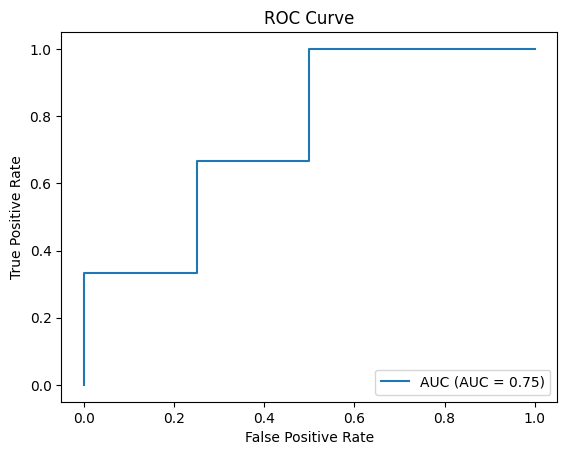

[1.95 0.95 0.85 0.8  0.55 0.45 0.3  0.1 ]
[0.         0.16666667 0.33333333 0.33333333 0.66666667 0.66666667
 1.         1.        ]
[0.   0.   0.   0.25 0.25 0.5  0.5  1.  ]


In [150]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(label, prob)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='AUC')
display.plot()
plt.title("ROC Curve")
plt.show()
print(thresholds)
print(tpr)
print(fpr)

In [138]:
# KNN
knn_pred, knn_probs = knn_classifier(X_train, y_train, X_test, k=5)

# Log
theta, loss_history, accuracy_history = train_logistic_regression(X_train_minmax, y_train, X_test_minmax, y_test)
log_preds = predict_logistic_regression(X_test_minmax, theta)
log_probs = probability(X_test_minmax, theta, y_test)

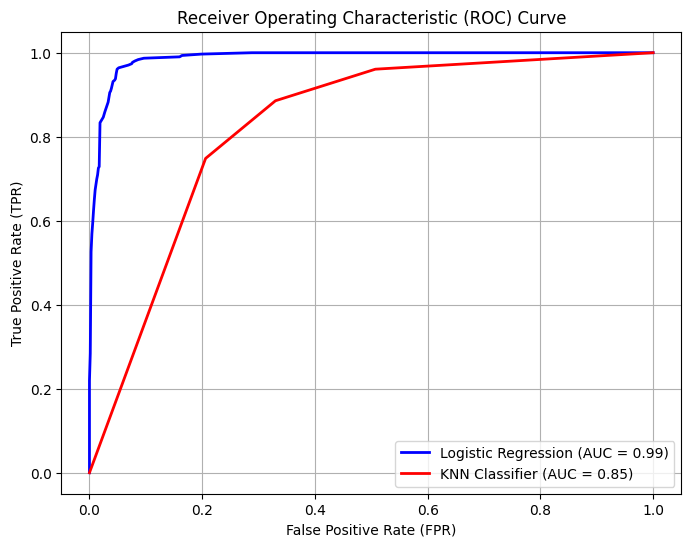

In [143]:
plot_roc_curve(log_probs, knn_probs, y_test)

# Sandbox

In [77]:
a = np.array([[0.825, 0.847, 0.838, 0.838, 0.862],
 [0.853, 0.851, 0.85, 0.862, 0.87],
 [0.862, 0.86, 0.873, 0.875, 0.876],
 [0.851, 0.88, 0.869, 0.874, 0.887],
 [0.775, 0.774, 0.779, 0.778, 0.781]])

In [79]:
a = a.mean(axis=0)
print(a)

[0.8332 0.8424 0.8418 0.8454 0.8552]
